<a href="https://colab.research.google.com/github/revinarnan/emotion-detection/blob/main/Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tugas Individu NLP - Sentiment Analysis
## Emotion Detection from Sample Tweets

**Muhammad Revin Arnan   18/429075/TK/47577**

In [ ]:
#Import library untuk persiapan data
from pprint import pprint
!pip install emoji

import re
import time
import emoji
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [ ]:
dataset = '/content/drive/My Drive/emotion-labels-train.csv'
data = pd.read_csv(dataset)
data

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy
...,...,...
3608,@VivienLloyd Thank you so much! Just home - st...,sadness
3609,Just put the winter duvet on ☃️❄️🌬☔️,sadness
3610,@SilkInSide @TommyJoeRatliff that's so pretty!...,sadness
3611,@BluesfestByron second artist announcement loo...,sadness


# Explore Dataset

In [ ]:
#Check missing value
data.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
#Melihat informasi pada dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613 entries, 0 to 3612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3613 non-null   object
 1   label   3613 non-null   object
dtypes: object(2)
memory usage: 56.6+ KB


In [ ]:
data.shape

(3613, 2)

In [ ]:
#Jumlah data unik pada kolom text lebih sedikit 
#dengan record yang ada, artinya ada duplikasi record
data.text.nunique()

3565

#Cleaning

In [ ]:
#Menghapus record yang terduplikasi
data = data.drop_duplicates(subset='text').reset_index(drop=True)
data.shape

(3565, 2)

In [ ]:
#Fungsi untuk membersihkan teks, dengan regex menghilangkan username twitter (@username)
#Merubah emoji menjadi teks, dan menghilangkan special character
def clean_text(text):
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'&\w+;', '', text)
  text = re.sub(r'\n', ' ', text)
  text = text.lower()
  text = emoji.demojize(text, delimiters=(' ', ' '))
  text = re.sub(r'[^a-z_]', ' ', text)

  return text

#Data Pre-Processing

In [ ]:
import nltk
nltk.download(['stopwords', 'punkt'])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Fungsi menghilangkan stopwords english dari text
def removed_words(word):
  filtered_words = []
  stops = set(stopwords.words('english'))
  stop_words = word_tokenize(word)
  filtered_words.append(' '.join(w for w in stop_words if w not in stops))
  
  return ' '.join(filtered_words)

In [ ]:
data['text'] = data['text'].apply([clean_text, removed_words])
data.head()

,text,label
0,just got back from seeing in burslem amazing...,joy
1,oh dear an evening of absolute hilarity i don ...,joy
2,been waiting all week for this game red_heart...,joy
3,thank you so much gloria you re so sweet ...,joy
4,i feel so blessed to work with the family that...,joy


In [ ]:
#Menghitung jumlah kata unik untuk menentukan jumlah features pada TF-IDF
from collections import Counter

array_text = ' '.join(data['text'].values)
array_text = array_text.split()
word_count = Counter(array_text)
len(word_count)

8365

In [ ]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

#Term weighting dengan TFIDF, menggunakan 1000 features
tfidf = TfidfVectorizer(sublinear_tf=True, max_features = 2000)
feat = tfidf.fit_transform(data.text)

In [ ]:
#Hasil pembobotan setiap kata
X = pd.DataFrame(feat.toarray(), columns=tfidf.get_feature_names())
X.head()

,_hand_light_skin_tone,ability,able,abortion,about,above,absolute,absolutely,acc,accept,access,account,across,act,acting,action,actually,add,added,addiction,address,adrenaline,adult,adventure,af,affliction,afraid,after,afternoon,again,against,age,agent,ages,aggravate,ago,ahead,ahs,ain,air,...,working,world,worried,worry,worse,worst,worth,worthless,would,wouldn,wow,wrath,writing,wrong,wtf,wwe,xbox,xmas,xx,ya,yeah,year,years,yelling,yep,yes,yesterday,yet,yikes,yo,yoga,you,young,your,yourself,youtube,yr,yrs,zero,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.343617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.307429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Transform string label agar menjadi integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(data.label)
y

array([2, 2, 2, ..., 3, 3, 3])

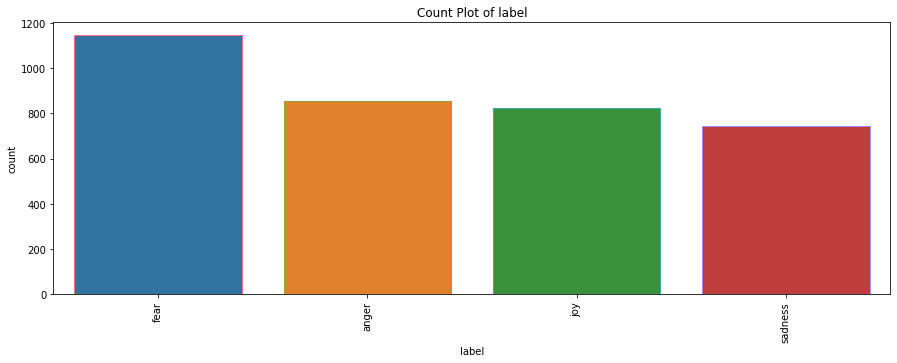

In [ ]:
#Melihat jumlah tiap label dengan menggunakan visualisasi
labels = list(data['label'].value_counts().index)

def showcountplot(plotuse,text=None,showtext = False):
    if text==None:
        text = []
    plt.figure(figsize=(15,5))
    ax = sns.countplot(plotuse,
                       linewidth=1,
                       edgecolor=sns.color_palette("husl",4),
                       order = plotuse.value_counts().index)
    #Set a title
    ax.set_title(f"Count Plot of {plotuse.name}")
    #Create text
    for index,value in enumerate(plotuse.value_counts()):
        if text == []:
            ax.set_xticklabels("")
        else:
            ax.set_xticklabels(text,rotation=90) 
    #Show our plot
    plt.show()

showcountplot(data['label'],text=labels,showtext=True)

In [ ]:
#Melakukan balancing data dengan algoritma SMOTE + TomekLinks
from imblearn.combine import SMOTETomek

st = SMOTETomek()
X_st, y_st = st.fit_resample(X, y)
print("SMOTE + TomekLinks")
print(f"Shape dari y: {len(y_st)}, dimana jumlah : {Counter(y_st)}")

SMOTE + TomekLinks
Shape dari y: 4582, dimana jumlah : Counter({2: 1146, 0: 1146, 1: 1145, 3: 1145})


#Training, Mencari Model Terbaik antara Support Vector Machine dan Random Forest

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Support Vector Machines
%%time
clf_svm = LinearSVC(max_iter=10, random_state=42)
score_svm = cross_val_score(clf_svm, X_st, y_st, cv=5, scoring='f1_macro')
print('Score:', score_svm)

Score: [0.88940062 0.89180684 0.88641842 0.8691483  0.92071947]
CPU times: user 1.28 s, sys: 277 ms, total: 1.56 s
Wall time: 1.6 s


In [ ]:
# Random Forest
%%time
clf_rf = RandomForestClassifier(random_state=42)
score_rf = cross_val_score(clf_rf, X_st, y_st, cv=5, scoring='f1_macro')
print('Score:', score_rf)

Score: [0.88360631 0.86464802 0.8413792  0.85411262 0.90359698]
CPU times: user 32.5 s, sys: 355 ms, total: 32.9 s
Wall time: 40.1 s


In [ ]:
#Model SVM dipilih karena komputasi yang lebih cepat dan sedikit lebih baik dan stabil dari RF
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

#Cross validate training model SVM
svm = clf_svm.fit(X_st, y_st)
kfold = KFold(n_splits=5, random_state=1234, shuffle = True)
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average = 'weighted'),
           'recall' : make_scorer(recall_score, average = 'weighted'), 
           'f1_score' : make_scorer(f1_score, average = 'weighted'),
           'mean_absolute_error' : make_scorer(mae)}

results_svm = cross_validate(estimator=svm,X=X_st,
                                          y=y_st,
                                          cv=kfold,
                                          scoring=scoring)
result_df = pd.DataFrame(results_svm)
result_df

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score,test_mean_absolute_error
0,0.344114,0.092271,0.914940,0.914774,0.914940,0.914766,0.147219
1,0.370445,0.088871,0.920393,0.920583,0.920393,0.920349,0.114504
2,0.267389,0.056897,0.910480,0.910475,0.910480,0.910088,0.156114
3,0.267838,0.058686,0.906114,0.905941,0.906114,0.905993,0.160480
4,0.591920,0.063146,0.914847,0.915006,0.914847,0.914649,0.145197


#Validation

In [ ]:
#Validasi model degnan dataset khusus untuk validasi
dataset_val = '/content/drive/My Drive/emotion-labels-val.csv'
data_val = pd.read_csv(dataset_val)
data_val

,text,label
0,"@theclobra lol I thought maybe, couldn't decid...",joy
1,Nawaz Sharif is getting more funnier than @kap...,joy
2,Nawaz Sharif is getting more funnier than @kap...,joy
3,@tomderivan73 😁...I'll just people watch and e...,joy
4,I love my family so much #lucky #grateful #sma...,joy
...,...,...
342,Common app just randomly logged me out as I wa...,sadness
343,"I'd rather laugh with the rarest genius, in be...",sadness
344,If you #invest in my new #film I will stop ask...,sadness
345,"Just watched Django Unchained, Other people ma...",sadness


In [ ]:
#Pre-processing validation data
SVC = clf_svm.fit(X_st, y_st)

data_val['text'] = data_val['text'].apply([clean_text, removed_words])

val_X = data_val.iloc[:,0].values
val_y = data_val.iloc[:,-1].values
val_X1 = tfidf.transform(val_X).toarray()
val_y1 = le.transform(val_y)

In [ ]:
#Predict validation data
Yval = SVC.predict(val_X1)
print(classification_report(val_y1, Yval))
print(confusion_matrix(val_y1, Yval))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84        84
           1       0.88      0.83      0.85       110
           2       0.88      0.89      0.88        79
           3       0.78      0.82      0.80        74

    accuracy                           0.84       347
   macro avg       0.84      0.85      0.84       347
weighted avg       0.85      0.84      0.84       347

[[71  2  4  7]
 [ 9 91  2  8]
 [ 2  5 70  2]
 [ 3  6  4 61]]


#Predict

In [ ]:
#Memprediksi data pada dataset test
dataset_test = '/content/drive/My Drive/emotion-labels-test.csv'
data_test = pd.read_csv(dataset_test)
data_test

,text,label
0,You must be knowing #blithe means (adj.) Happ...,joy
1,Old saying 'A #smile shared is one gained for ...,joy
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,joy
3,@Elaminova sparkling water makes your life spa...,joy
4,I'm tired of everybody telling me to chill out...,joy
...,...,...
3137,Why does Candice constantly pout #GBBO 💄😒,sadness
3138,"@redBus_in #unhappy with #redbus CC, when I ta...",sadness
3139,"@AceOperative789 no pull him afew weeks ago, s...",sadness
3140,I'm buying art supplies and I'm debating how s...,sadness


In [ ]:
#Pre-processing testing dataset
data_test['text'] = data_test['text'].apply([clean_text, removed_words])

test_X = data_test.iloc[:,0].values
test_y = data_test.iloc[:,-1].values

test_X1 = tfidf.transform(test_X).toarray()
test_y1 = le.transform(test_y)

In [ ]:
#Memprediksi testing dataset
Ypred = SVC.predict(test_X1)
print(classification_report(test_y1, Ypred))
print('mean absolute error:', mae(test_y1, Ypred))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79       760
           1       0.83      0.75      0.79       995
           2       0.84      0.85      0.85       714
           3       0.73      0.78      0.76       673

    accuracy                           0.79      3142
   macro avg       0.79      0.80      0.79      3142
weighted avg       0.80      0.79      0.79      3142

mean absolute error: 0.354551241247613


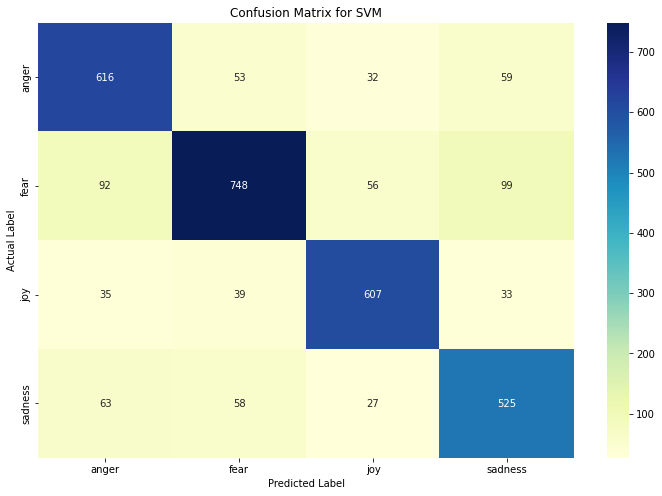

In [ ]:
#Menampilkan confusiom matrix dari hasil test Linear SVM

y1 = le.inverse_transform(test_y1)
label = pd.DataFrame(data={'Label_Encoder':test_y1, 'label':y1})
label_df = label.drop_duplicates()
label_df = label_df.sort_values(by='Label_Encoder', ascending=True)
label_df = label_df.reset_index(drop=True)

cm_svm = confusion_matrix(test_y1, Ypred)
plt.subplots(figsize=(12,8))
sns.heatmap(pd.DataFrame(cm_svm), annot=True, cmap="YlGnBu",
            fmt='g', yticklabels=label_df['label'], xticklabels=label_df['label'])
plt.title('Confusion Matrix for SVM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()